In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.boolean_reasoning"

In [2]:
#instead of installing library...
from config import library_path,snapshot_path

AgentNet examples will store and seek thier snapshots at /home/jheuristic/yozhik/agentnet_snapshots/


In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [5]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [6]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [7]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [8]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [10]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [11]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights
 
 
 #### Get (prediction,reference) pairs

In [12]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


reference_Qvalues = qlearning.get_reference(qvalues_seq,
                               action_seq,
                               rewards_seq,
                               gamma_or_gammas=gamma,)

In [13]:
#zero-out future rewards at session end
from agentnet.utils.mdp import get_end_indicator

end_action_ids = get_end_indicator(is_alive_seq).nonzero()

# "set reference Qvalues at end action ids to just the immediate rewards"
reference_Qvalues = T.set_subtensor(reference_Qvalues[end_action_ids],
                                    rewards_seq[end_action_ids])

In [14]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from agentnet.utils import consider_constant
reference_Qvalues = consider_constant(reference_Qvalues)

In [15]:
#get predicted qvalues for commited actions (to compare with reference Qvalues)
from agentnet.utils.mdp import get_action_Qvalues

action_Qvalues = get_action_Qvalues(qvalues_seq,action_seq)

#### Define loss functions

In [16]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#compute average of squared error sums per session
session_mse_loss = squared_error.sum(axis = 1).mean()

In [17]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [18]:
loss = session_mse_loss + reg_l2

#### Compute weight updates

In [19]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [20]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [21]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,session_mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [22]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   reference_qvalues_seq = reference_qv_log,
                   action_names=env.feature_names,
                  
                  plot_qvalues = with_plots)

session # 0
 X1(qv = 0.0) -> -1.0(ref = -0.958864033222) |  X3(qv = 0.0433010235429) -> -1.0(ref = -0.979850113392) |  X3(qv = 0.0212104041129) -> -0.5(ref = -0.481374889612) |  Y1(qv = 0.0196053683758) -> 3.0(ref = 3.08607172966) |  Y1(qv = 0.0906017497182) -> -0.5(ref = -0.373619794846) |  Y2(qv = 0.133031785488) -> -3.0(ref = -2.92352747917) |  X3(qv = -0.0553351268172) -> -0.5(ref = -0.446942925453) |  Y1(qv = 0.0558495596051) -> -0.5(ref = -0.397827029228) |  Y2(qv = 0.107254818082) -> -0.5(ref = -0.410317420959) |  X1(qv = 0.0944027304649) -> -0.5(ref = -0.5) |

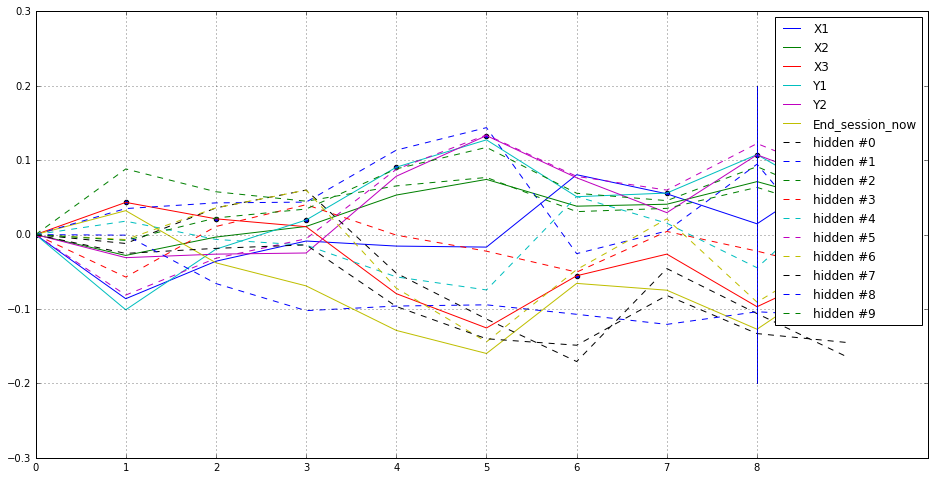

In [23]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [24]:
from agentnet.utils.persistence import save,load

In [25]:
from agentnet.display import Metrics
score_log = Metrics()

In [26]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 13.60245, epsilon 0.96275, rewards: ( e-greedy -0.09333, greedy 0.00000) 
rec 13.589 reg 0.013
epoch 200,loss 9.18049, epsilon 0.92696, rewards: ( e-greedy -0.18567, greedy -0.18500) 
rec 9.167 reg 0.013
epoch 300,loss 12.71520, epsilon 0.89257, rewards: ( e-greedy -0.28543, greedy -0.20983) 
rec 12.701 reg 0.014
epoch 400,loss 9.66583, epsilon 0.85954, rewards: ( e-greedy -0.24356, greedy -0.05552) 
rec 9.652 reg 0.014
epoch 500,loss 12.44103, epsilon 0.82779, rewards: ( e-greedy -0.26587, greedy 0.03504) 
rec 12.426 reg 0.015
epoch 600,loss 8.59396, epsilon 0.79730, rewards: ( e-greedy -0.21928, greedy 0.23153) 
rec 8.578 reg 0.016
epoch 700,loss 10.32122, epsilon 0.76799, rewards: ( e-greedy -0.21735, greedy 0.44838) 
rec 10.305 reg 0.017
epoch 800,loss 8.58213, epsilon 0.73984, rewards: ( e-greedy -0.21395, greedy 0.56354) 
rec 8.564 reg 0.018
epoch 900,loss 9.84820, epsilon 0.71279, rewards: ( e-greedy -0.21089, greedy 0.74719) 
rec 9.828 reg 0.020
epoch 1000,loss 1

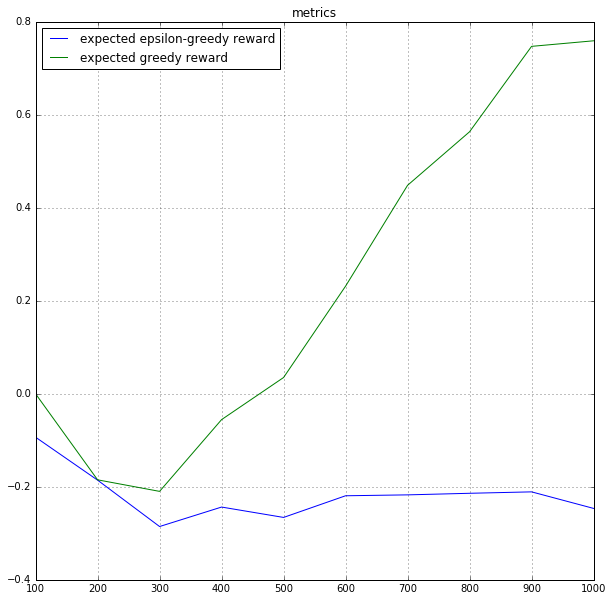

Random session examples
session # 0
 X3(qv = 0.127773240209) -> -1.0(ref = 0.062791466713) |  Y2(qv = 1.11872792244) -> 3.0(ref = 3.1779820919) |  Y1(qv = -1.00260984898) -> -3.0(ref = -2.75305914879) |  X1(qv = 0.259937673807) -> 1.0(ref = 1.27900564671) |  Y2(qv = 0.293690174818) -> -0.5(ref = -0.503801524639) |  X1(qv = -0.0040016323328) -> -0.5(ref = -0.594138860703) |  End_session_now(qv = -0.0990935266018) -> 0.0(ref = -0.0788966342807) |  X3(qv = -0.0830490887165) -> 0.0(ref = 0.0) | 



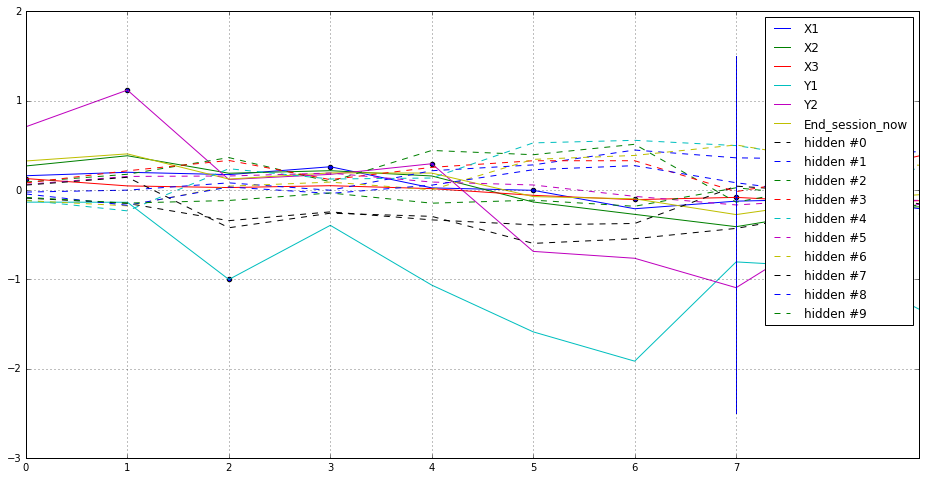

session # 1
 Y2(qv = 0.707927405834) -> 3.0(ref = 3.12920117378) |  X1(qv = 0.136001288891) -> -1.0(ref = -0.844547867775) |  Y1(qv = -1.02201700211) -> -3.0(ref = -2.72769784927) |  X3(qv = 0.0700676888227) -> -1.0(ref = -0.355171442032) |  X1(qv = 0.177293345332) -> -0.5(ref = 0.396691381931) |  Y1(qv = -0.461133003235) -> -0.5(ref = 0.576090574265) |  X1(qv = 0.282729297876) -> -0.5(ref = 0.810909509659) |  X2(qv = 0.514389753342) -> -1.0(ref = 0.448475122452) |  End_session_now(qv = 0.581486284733) -> 0.0(ref = 0.899337232113) |  X2(qv = 0.35880702734) -> 0.0(ref = 0.0) |

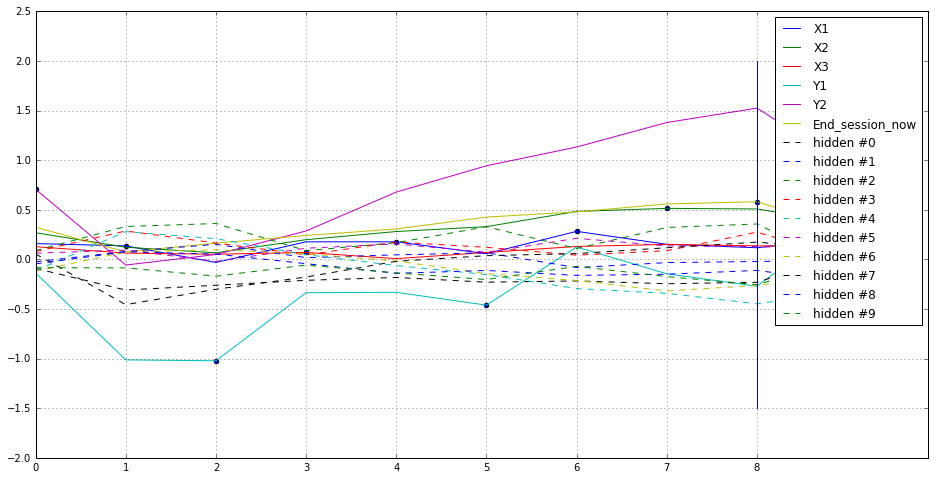

 session # 2
 End_session_now(qv = 0.324624896049) -> 0.0(ref = 0.516584277153) |  Y1(qv = 0.398729681969) -> 0.0(ref = 0.0) | 



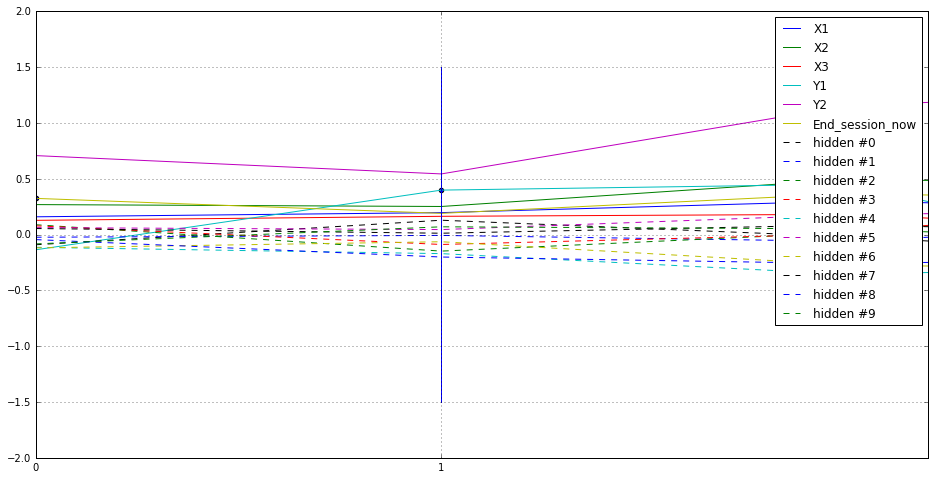

epoch 1100,loss 8.71933, epsilon 0.66183, rewards: ( e-greedy -0.21015, greedy 0.92322) 
rec 8.695 reg 0.024
epoch 1200,loss 9.77217, epsilon 0.63784, rewards: ( e-greedy -0.17080, greedy 1.06923) 
rec 9.746 reg 0.026
epoch 1300,loss 9.41350, epsilon 0.61479, rewards: ( e-greedy -0.10206, greedy 1.16898) 
rec 9.385 reg 0.028
epoch 1400,loss 8.33908, epsilon 0.59265, rewards: ( e-greedy -0.04852, greedy 1.25208) 
rec 8.309 reg 0.030
epoch 1500,loss 8.31739, epsilon 0.57137, rewards: ( e-greedy -0.01367, greedy 1.31354) 
rec 8.285 reg 0.033
epoch 1600,loss 8.20540, epsilon 0.55093, rewards: ( e-greedy 0.02603, greedy 1.35885) 
rec 8.171 reg 0.035
epoch 1700,loss 6.61156, epsilon 0.53129, rewards: ( e-greedy 0.11843, greedy 1.47796) 
rec 6.575 reg 0.036
epoch 1800,loss 7.40533, epsilon 0.51241, rewards: ( e-greedy 0.16825, greedy 1.54350) 
rec 7.367 reg 0.038
epoch 1900,loss 6.73888, epsilon 0.49428, rewards: ( e-greedy 0.29809, greedy 1.59248) 
rec 6.699 reg 0.040
epoch 2000,loss 7.58625

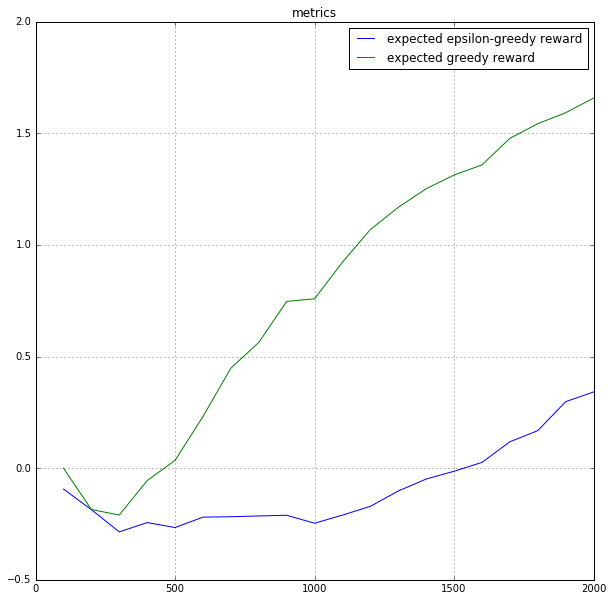

Random session examples
session # 0
 X3(qv = 0.808670163155) -> -1.0(ref = 1.11365938187) |  Y2(qv = 2.2249045372) -> 3.0(ref = 3.22427630424) |  X1(qv = 0.236080259085) -> -1.0(ref = -0.888875722885) |  End_session_now(qv = 0.116972923279) -> 0.0(ref = 0.0425237156451) |  X1(qv = -0.00173944234848) -> 0.0(ref = 0.0) | 



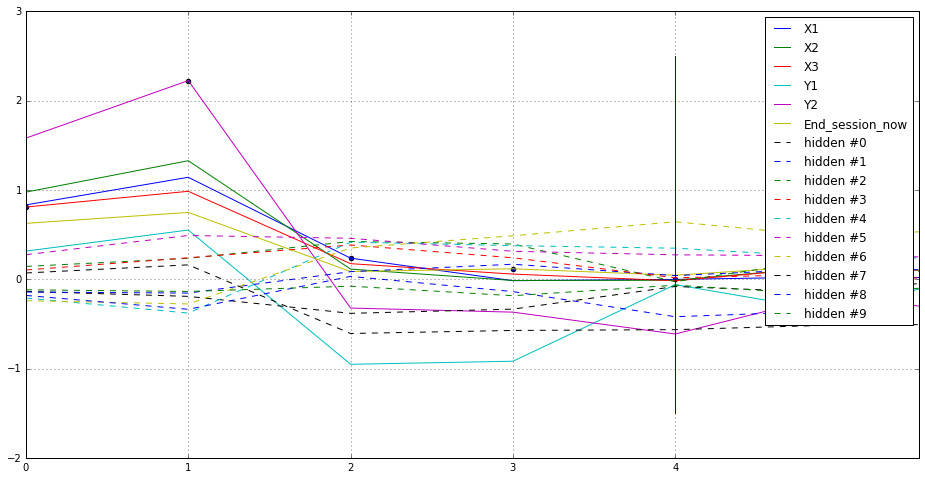

session # 1
 Y2(qv = 1.58065402508) -> 3.0(ref = 3.1541621685) |  X1(qv = 0.162276044488) -> -1.0(ref = -0.885409116745) |  End_session_now(qv = 0.120622009039) -> 0.0(ref = 0.0467502474785) |  X1(qv = -0.000845611095428) -> 0.0(ref = 0.0) | 



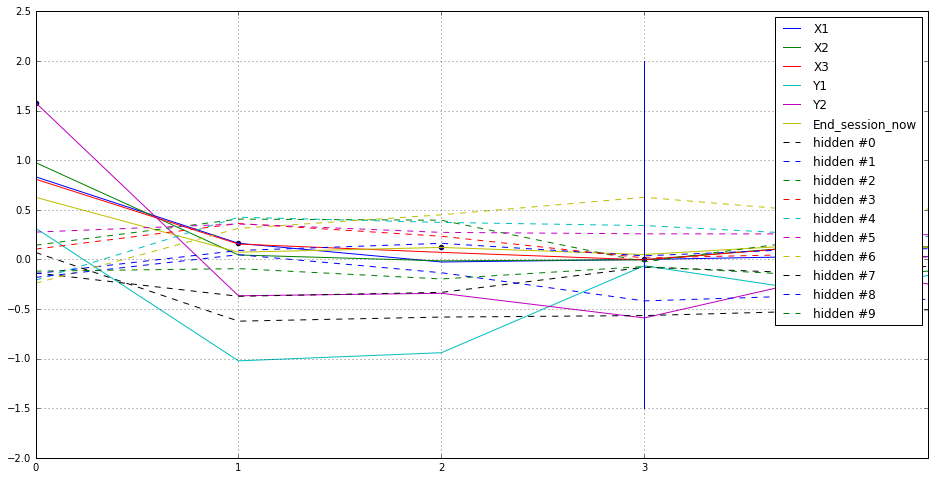

session # 2
 X3(qv = 0.808670163155) -> 1.0(ref = 2.45166683197) |  Y2(qv = 1.52807021141) -> -3.0(ref = -2.57976651192) |  X2(qv = 0.442351043224) -> 1.0(ref = 1.09472703934) |  End_session_now(qv = 0.0997126996517) -> 0.0(ref = 0.0441428609192) |  X1(qv = -0.00344318151474) -> 0.0(ref = 0.0) | 



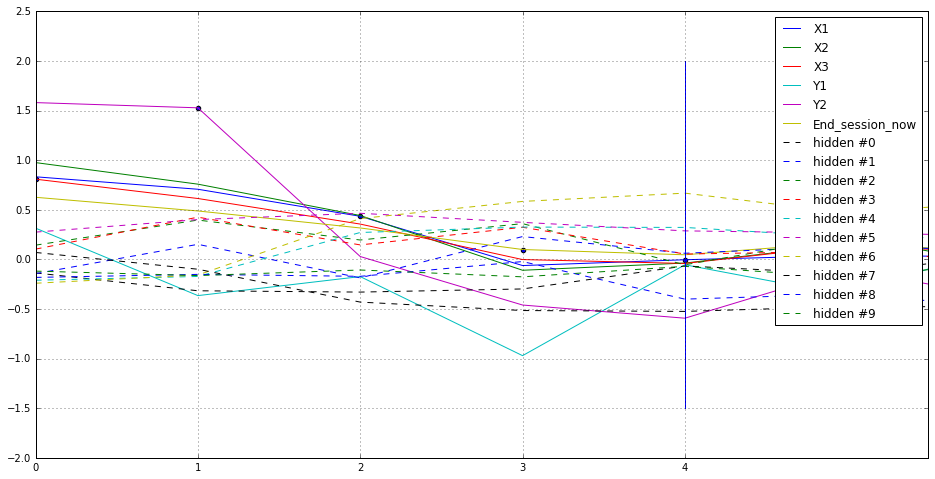

epoch 2100,loss 6.99217, epsilon 0.46012, rewards: ( e-greedy 0.29412, greedy 1.67741) 
rec 6.949 reg 0.043
epoch 2200,loss 7.31701, epsilon 0.44404, rewards: ( e-greedy 0.39304, greedy 1.70800) 
rec 7.272 reg 0.045
epoch 2300,loss 6.34634, epsilon 0.42859, rewards: ( e-greedy 0.48874, greedy 1.78220) 
rec 6.300 reg 0.047
epoch 2400,loss 6.49615, epsilon 0.41375, rewards: ( e-greedy 0.50987, greedy 1.80065) 
rec 6.448 reg 0.048
epoch 2500,loss 5.02104, epsilon 0.39949, rewards: ( e-greedy 0.59388, greedy 1.85225) 
rec 4.971 reg 0.050
epoch 2600,loss 8.47833, epsilon 0.38578, rewards: ( e-greedy 0.57116, greedy 1.79869) 
rec 8.427 reg 0.051
epoch 2700,loss 8.81415, epsilon 0.37262, rewards: ( e-greedy 0.63071, greedy 1.76882) 
rec 8.761 reg 0.053
epoch 2800,loss 6.14417, epsilon 0.35997, rewards: ( e-greedy 0.64430, greedy 1.81361) 
rec 6.090 reg 0.054
epoch 2900,loss 7.71781, epsilon 0.34781, rewards: ( e-greedy 0.66654, greedy 1.83225) 
rec 7.662 reg 0.056
epoch 3000,loss 6.98764, eps

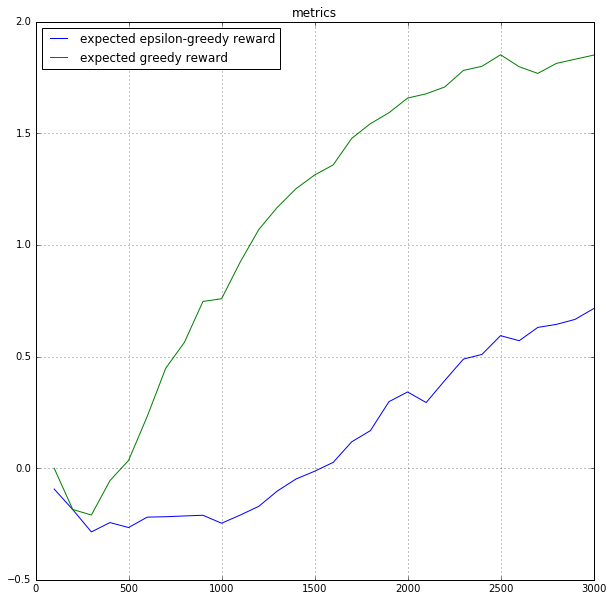

Random session examples
session # 0
 X2(qv = 1.29881548882) -> -1.0(ref = 1.08092045784) |  X1(qv = 1.30319309235) -> 1.0(ref = 2.35077857971) |  Y2(qv = 1.42187213898) -> 3.0(ref = 3.03966712952) |  End_session_now(qv = 0.0417547821999) -> 0.0(ref = 0.0131341172382) |  End_session_now(qv = 0.0138253867626) -> 0.0(ref = 0.0) | 



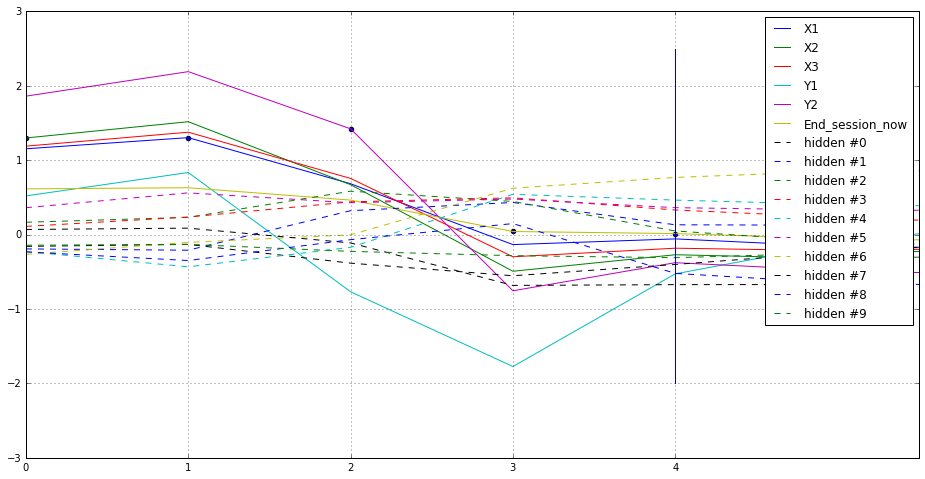

session # 1
 X3(qv = 1.18877470493) -> -1.0(ref = 1.18378424644) |  Y2(qv = 2.2987203598) -> 3.0(ref = 3.25160932541) |  X1(qv = 0.264852046967) -> 1.0(ref = 1.00364112854) |  X1(qv = -0.349887669086) -> -0.5(ref = -0.485268861055) |  End_session_now(qv = 0.0155064761639) -> 0.0(ref = 0.0457876585424) |  End_session_now(qv = 0.0481975376606) -> 0.0(ref = 0.0) | 



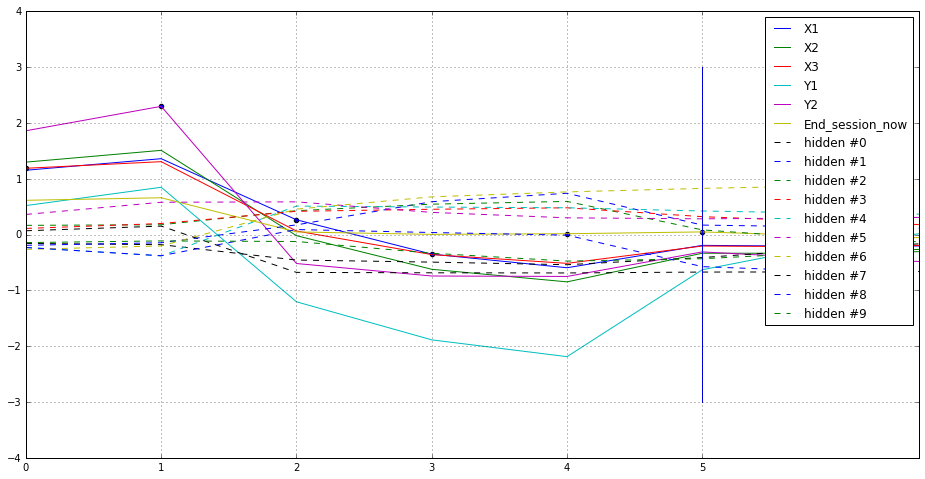

session # 2
 Y2(qv = 1.86088120937) -> 3.0(ref = 3.22726535797) |  X1(qv = 0.239226818085) -> 1.0(ref = 1.00555336475) |  End_session_now(qv = 0.0058456659317) -> 0.0(ref = 0.0192641913891) |  End_session_now(qv = 0.020278096199) -> 0.0(ref = 0.0) | 



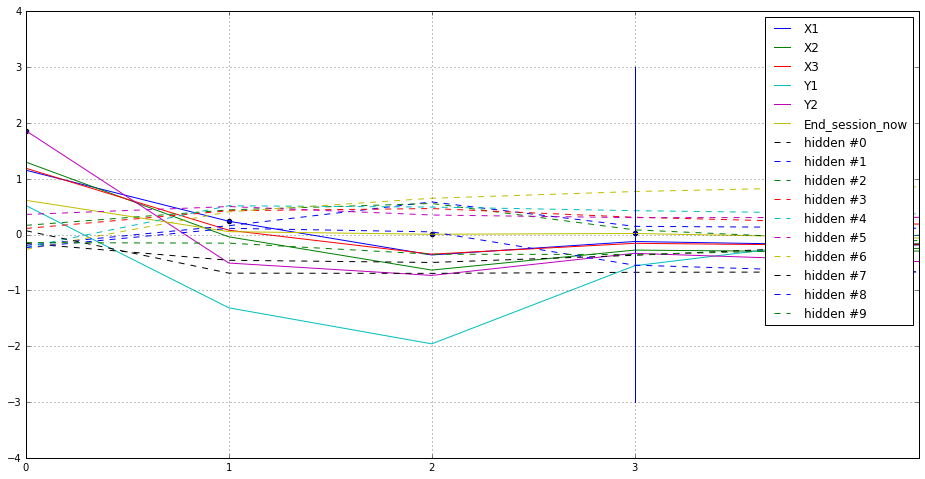

epoch 3100,loss 6.90472, epsilon 0.32492, rewards: ( e-greedy 0.77340, greedy 1.85395) 
rec 6.847 reg 0.058
epoch 3200,loss 5.87496, epsilon 0.31414, rewards: ( e-greedy 0.89106, greedy 1.94523) 
rec 5.816 reg 0.059
epoch 3300,loss 6.86793, epsilon 0.30378, rewards: ( e-greedy 1.02862, greedy 1.98737) 
rec 6.807 reg 0.061
epoch 3400,loss 5.68871, epsilon 0.29383, rewards: ( e-greedy 1.16909, greedy 2.07530) 
rec 5.626 reg 0.063
epoch 3500,loss 8.90926, epsilon 0.28427, rewards: ( e-greedy 1.18885, greedy 2.09444) 
rec 8.844 reg 0.066
epoch 3600,loss 6.36783, epsilon 0.27508, rewards: ( e-greedy 1.26663, greedy 2.18166) 
rec 6.298 reg 0.070
epoch 3700,loss 5.95299, epsilon 0.26626, rewards: ( e-greedy 1.26997, greedy 2.22349) 
rec 5.879 reg 0.074
epoch 3800,loss 5.51671, epsilon 0.25778, rewards: ( e-greedy 1.34630, greedy 2.29281) 
rec 5.440 reg 0.076
epoch 3900,loss 5.11318, epsilon 0.24963, rewards: ( e-greedy 1.35334, greedy 2.33353) 
rec 5.034 reg 0.079
epoch 4000,loss 4.98345, eps

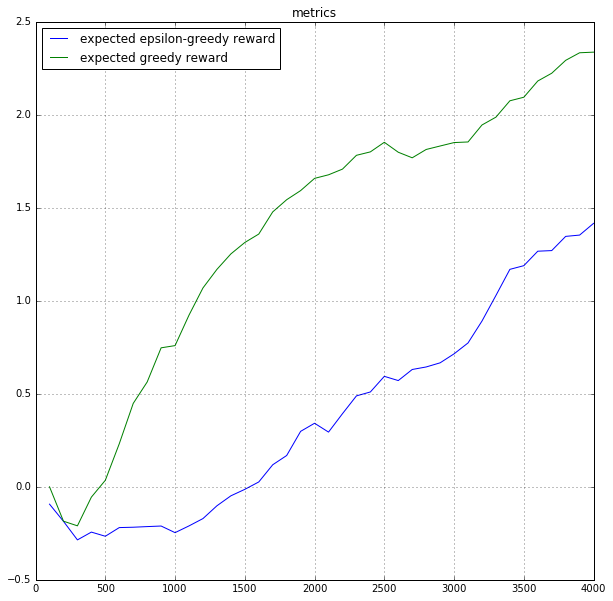

Random session examples
session # 0
 Y2(qv = 2.2755613327) -> -3.0(ref = -0.233340263367) |  Y1(qv = 2.91227340698) -> 3.0(ref = 3.82655096054) |  End_session_now(qv = 0.317561000586) -> 0.0(ref = 0.239459231496) |  X3(qv = 0.21359705925) -> 0.0(ref = 0.0) | 



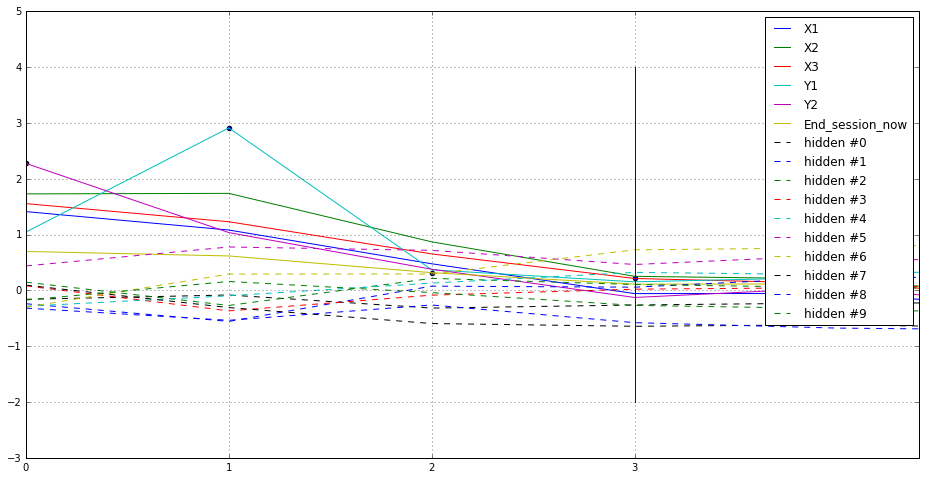

session # 1
 Y2(qv = 2.2755613327) -> -3.0(ref = -0.233340263367) |  Y1(qv = 2.91227340698) -> 3.0(ref = 3.82655096054) |  X2(qv = 0.870053648949) -> 1.0(ref = 1.10740947723) |  End_session_now(qv = 0.113062560558) -> 0.0(ref = 0.0642392635345) |  End_session_now(qv = 0.0676202774048) -> 0.0(ref = 0.0) | 



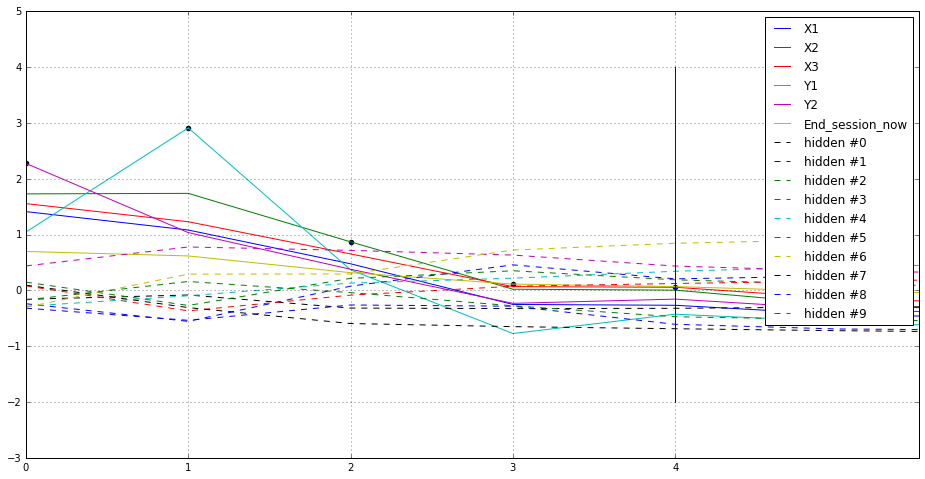

session # 2
 Y2(qv = 2.2755613327) -> 3.0(ref = 3.22348880768) |  X1(qv = 0.235251486301) -> -1.0(ref = -0.991298913956) |  End_session_now(qv = 0.00915905833244) -> 0.0(ref = -0.00614247471094) |  End_session_now(qv = -0.00646576285362) -> 0.0(ref = 0.0) | 



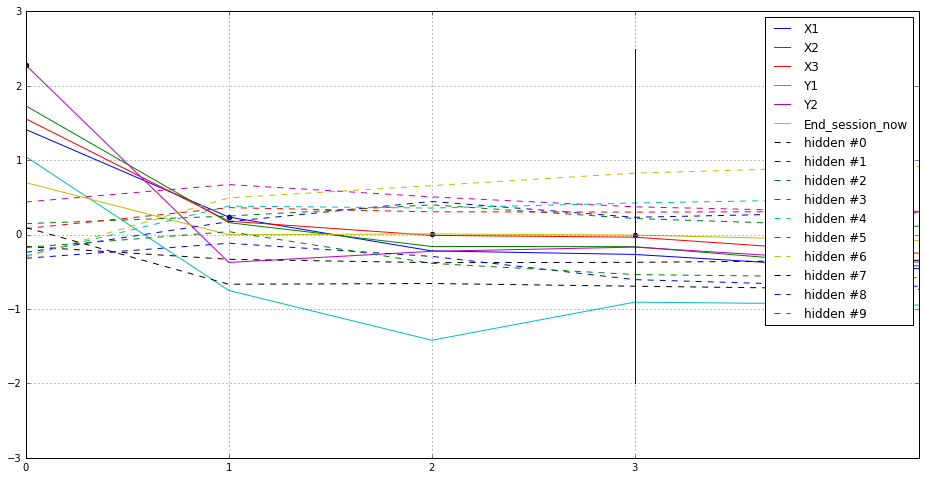

epoch 4100,loss 3.57223, epsilon 0.23428, rewards: ( e-greedy 1.48804, greedy 2.38983) 
rec 3.488 reg 0.084
epoch 4200,loss 3.54808, epsilon 0.22706, rewards: ( e-greedy 1.55423, greedy 2.46418) 
rec 3.462 reg 0.086
epoch 4300,loss 3.78982, epsilon 0.22011, rewards: ( e-greedy 1.57714, greedy 2.45109) 
rec 3.702 reg 0.088
epoch 4400,loss 4.05860, epsilon 0.21344, rewards: ( e-greedy 1.58610, greedy 2.46598) 
rec 3.969 reg 0.090
epoch 4500,loss 3.06466, epsilon 0.20703, rewards: ( e-greedy 1.59749, greedy 2.44938) 
rec 2.974 reg 0.091
epoch 4600,loss 2.25405, epsilon 0.20088, rewards: ( e-greedy 1.63774, greedy 2.51111) 
rec 2.162 reg 0.093
epoch 4700,loss 2.69054, epsilon 0.19496, rewards: ( e-greedy 1.71230, greedy 2.54333) 
rec 2.597 reg 0.094
epoch 4800,loss 2.59841, epsilon 0.18928, rewards: ( e-greedy 1.81107, greedy 2.56567) 
rec 2.504 reg 0.095
epoch 4900,loss 2.78668, epsilon 0.18382, rewards: ( e-greedy 1.87829, greedy 2.57243) 
rec 2.691 reg 0.096
epoch 5000,loss 2.40147, eps

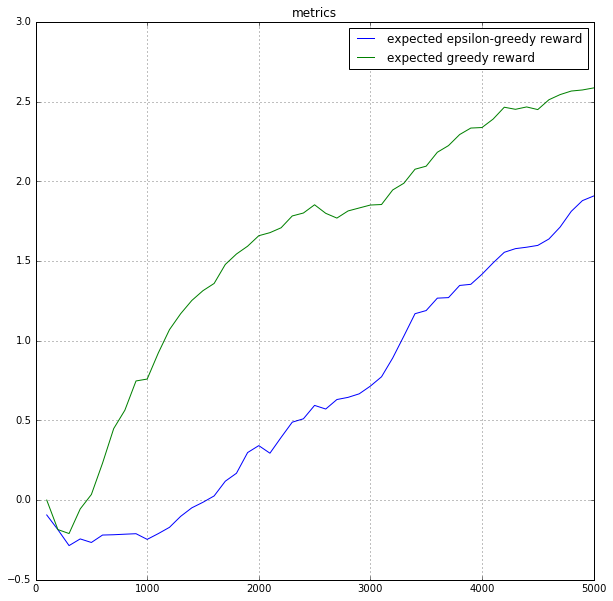

Random session examples
session # 0
 Y2(qv = 2.61982584) -> 3.0(ref = 3.32247018814) |  X1(qv = 0.339442431927) -> -1.0(ref = -0.976932823658) |  End_session_now(qv = 0.0242812335491) -> 0.0(ref = 0.0166253801435) |  X3(qv = 0.0175004005432) -> 0.0(ref = 0.0) | 



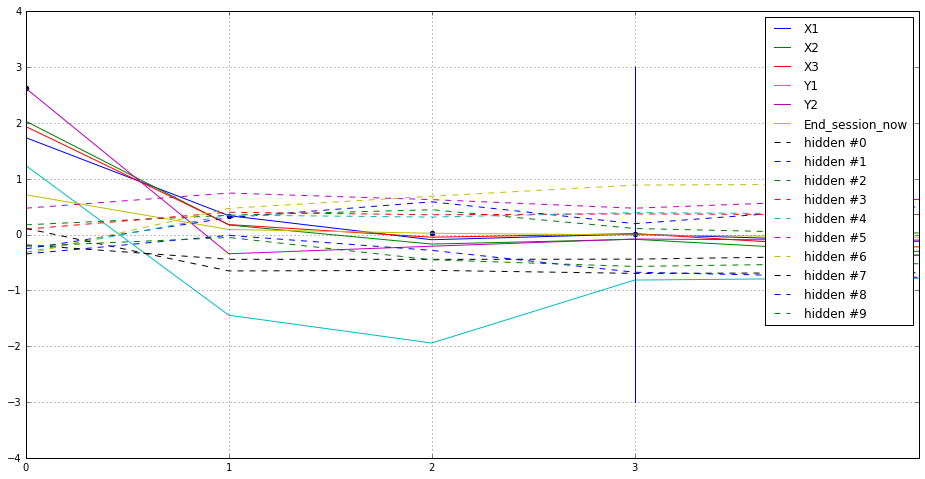

session # 1
 Y2(qv = 2.61982584) -> 3.0(ref = 3.32247018814) |  X1(qv = 0.339442431927) -> 1.0(ref = 1.01971364021) |  End_session_now(qv = 0.0207512080669) -> 0.0(ref = 0.0397379659116) |  X1(qv = 0.0418294370174) -> 0.0(ref = 0.0) | 



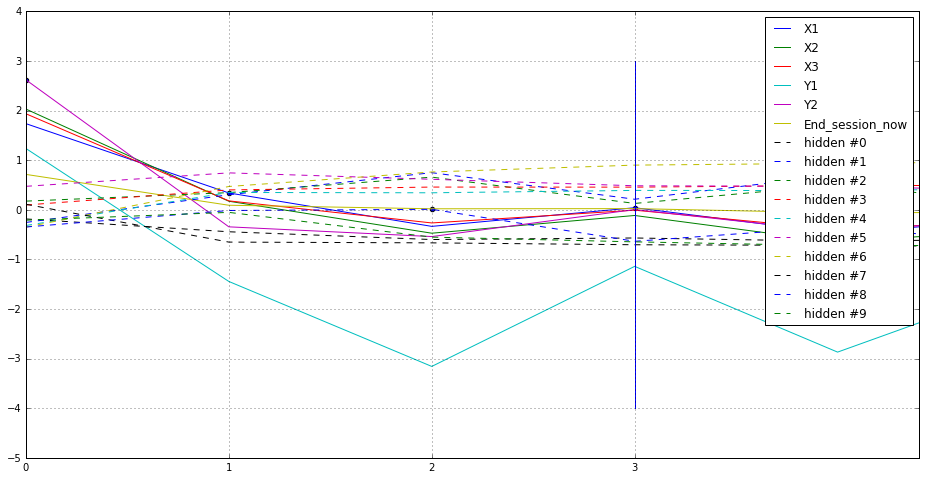

session # 2
 Y2(qv = 2.61982607841) -> -3.0(ref = 0.581222295761) |  Y1(qv = 3.76970767975) -> 3.0(ref = 3.98256492615) |  X2(qv = 1.03427898884) -> 1.0(ref = 1.09513354301) |  End_session_now(qv = 0.10014051199) -> 0.0(ref = 0.0493690408766) |  X2(qv = 0.0519674122334) -> 0.0(ref = 0.0) | 



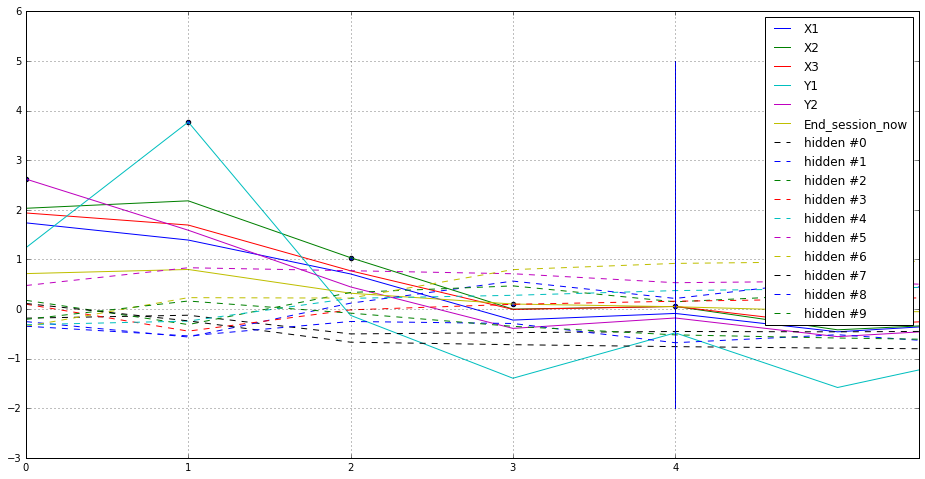

epoch 5100,loss 3.39964, epsilon 0.17353, rewards: ( e-greedy 1.89309, greedy 2.53334) 
rec 3.302 reg 0.098
epoch 5200,loss 2.31917, epsilon 0.16868, rewards: ( e-greedy 1.92378, greedy 2.56000) 
rec 2.220 reg 0.099
epoch 5300,loss 3.32193, epsilon 0.16403, rewards: ( e-greedy 1.94307, greedy 2.55734) 
rec 3.222 reg 0.100
epoch 5400,loss 2.64251, epsilon 0.15956, rewards: ( e-greedy 1.96043, greedy 2.55494) 
rec 2.542 reg 0.100
epoch 5500,loss 1.76936, epsilon 0.15526, rewards: ( e-greedy 2.00772, greedy 2.62278) 
rec 1.669 reg 0.101
epoch 5600,loss 2.31397, epsilon 0.15114, rewards: ( e-greedy 2.05194, greedy 2.67050) 
rec 2.212 reg 0.102
epoch 5700,loss 2.19458, epsilon 0.14717, rewards: ( e-greedy 2.06175, greedy 2.66678) 
rec 2.093 reg 0.102
epoch 5800,loss 1.84845, epsilon 0.14336, rewards: ( e-greedy 2.10558, greedy 2.70677) 
rec 1.746 reg 0.103
epoch 5900,loss 1.73050, epsilon 0.13970, rewards: ( e-greedy 2.17335, greedy 2.72943) 
rec 1.627 reg 0.103
epoch 6000,loss 2.42769, eps

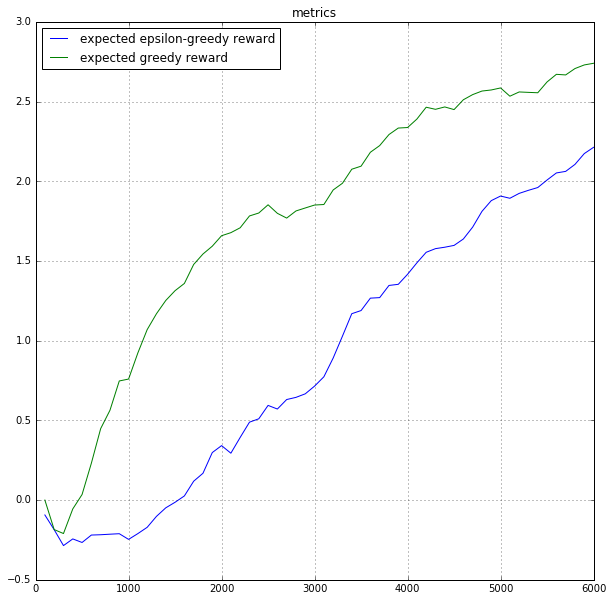

Random session examples
session # 0
 Y2(qv = 2.63724040985) -> 3.0(ref = 3.29345774651) |  X1(qv = 0.308902949095) -> -1.0(ref = -1.01011145115) |  End_session_now(qv = -0.0106436908245) -> 0.0(ref = -0.0280026681721) |  End_session_now(qv = -0.029476493597) -> 0.0(ref = 0.0) | 



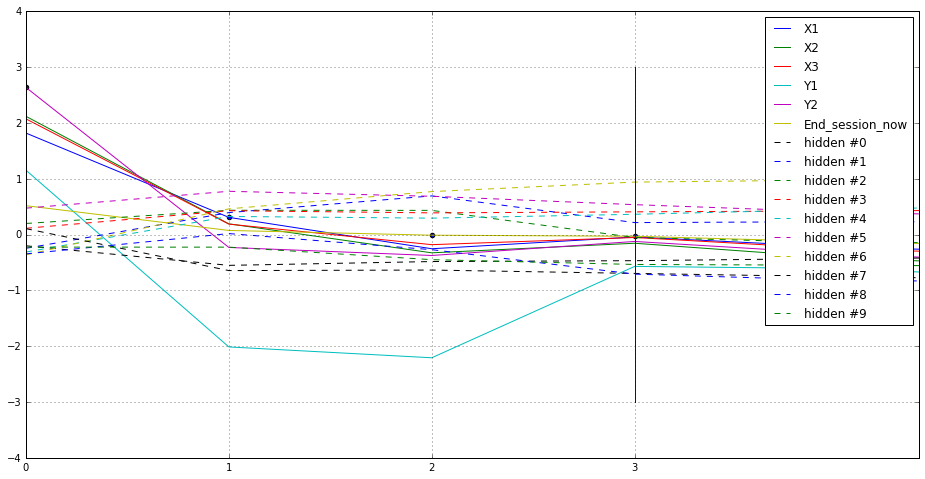

session # 1
 X3(qv = 2.07380080223) -> -1.0(ref = 2.04791259766) |  Y2(qv = 3.20832920074) -> -3.0(ref = 1.15539741516) |  Y1(qv = 4.37410259247) -> 3.0(ref = 4.11232185364) |  X2(qv = 1.17086493969) -> 1.0(ref = 1.05815446377) |  X2(qv = 0.0612152218819) -> -0.5(ref = -0.534920275211) |  End_session_now(qv = -0.0367582142353) -> 0.0(ref = -0.00775406183675) |  End_session_now(qv = -0.00816217064857) -> 0.0(ref = 0.0) | 



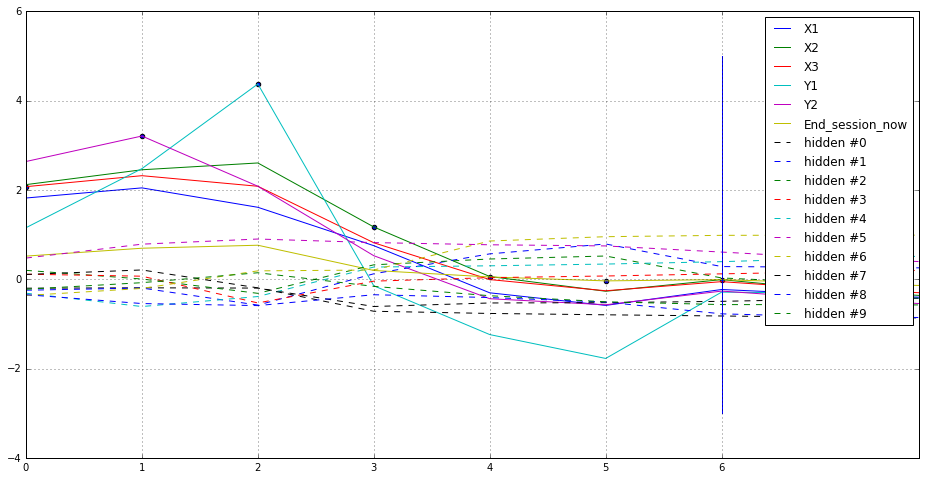

session # 2
 Y2(qv = 2.63724088669) -> 3.0(ref = 3.29345774651) |  X3(qv = 0.187824785709) -> -1.0(ref = -1.00230383873) |  Y2(qv = -0.154199779034) -> -0.5(ref = -0.590586781502) |  End_session_now(qv = -0.0953544974327) -> 0.0(ref = -0.0399738065898) |  X1(qv = -0.0420776903629) -> 0.0(ref = 0.0) | 



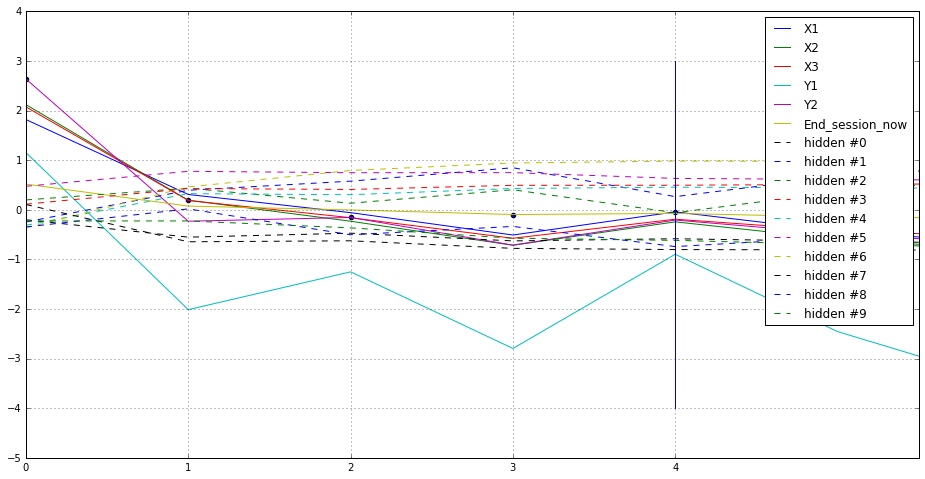

epoch 6100,loss 2.31681, epsilon 0.13280, rewards: ( e-greedy 2.22141, greedy 2.73917) 
rec 2.213 reg 0.104
epoch 6200,loss 1.89854, epsilon 0.12956, rewards: ( e-greedy 2.29927, greedy 2.78525) 
rec 1.794 reg 0.104
epoch 6300,loss 1.98444, epsilon 0.12644, rewards: ( e-greedy 2.34268, greedy 2.80339) 
rec 1.880 reg 0.105
epoch 6400,loss 2.64229, epsilon 0.12344, rewards: ( e-greedy 2.33174, greedy 2.77305) 
rec 2.537 reg 0.105
epoch 6500,loss 2.41522, epsilon 0.12056, rewards: ( e-greedy 2.33690, greedy 2.75908) 
rec 2.310 reg 0.105
epoch 6600,loss 2.65055, epsilon 0.11779, rewards: ( e-greedy 2.32655, greedy 2.71651) 
rec 2.545 reg 0.106
epoch 6700,loss 1.87259, epsilon 0.11513, rewards: ( e-greedy 2.34223, greedy 2.74152) 
rec 1.767 reg 0.106
epoch 6800,loss 2.41049, epsilon 0.11258, rewards: ( e-greedy 2.32634, greedy 2.70070) 
rec 2.305 reg 0.106
epoch 6900,loss 1.60289, epsilon 0.11013, rewards: ( e-greedy 2.38037, greedy 2.75063) 
rec 1.497 reg 0.106
epoch 7000,loss 2.48104, eps

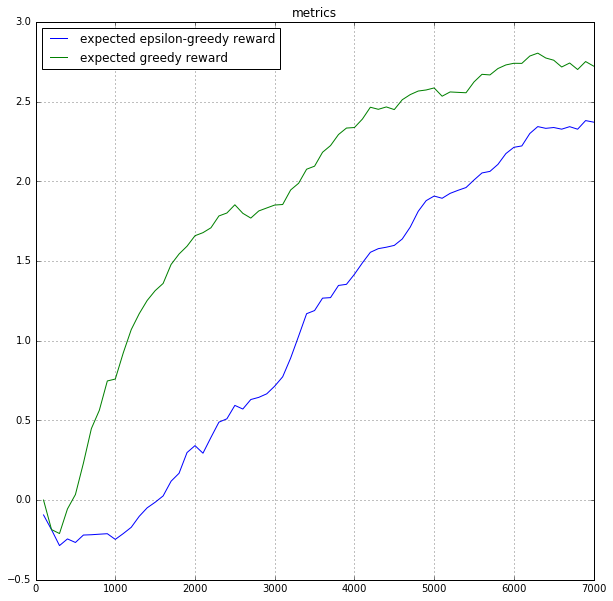

Random session examples
session # 0
 Y2(qv = 2.65323257446) -> 3.0(ref = 3.28674650192) |  X1(qv = 0.301838427782) -> 1.0(ref = 1.01980364323) |  End_session_now(qv = 0.0208458900452) -> 0.0(ref = 0.0277729146183) |  X1(qv = 0.0292346477509) -> 0.0(ref = 0.0) | 



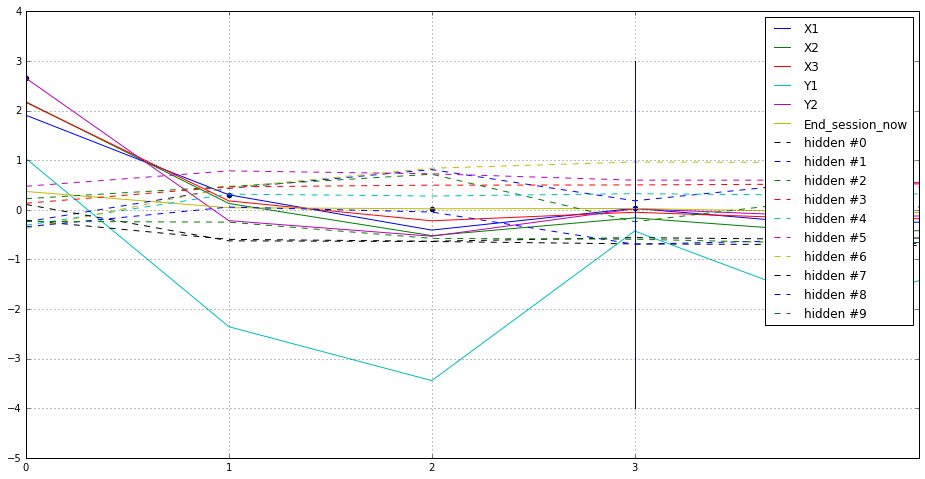

session # 1
 Y2(qv = 2.65323257446) -> 3.0(ref = 3.28674650192) |  X1(qv = 0.301838427782) -> 1.0(ref = 1.01980364323) |  End_session_now(qv = 0.0208458900452) -> 0.0(ref = 0.0277729146183) |  X1(qv = 0.0292346477509) -> 0.0(ref = 0.0) | 



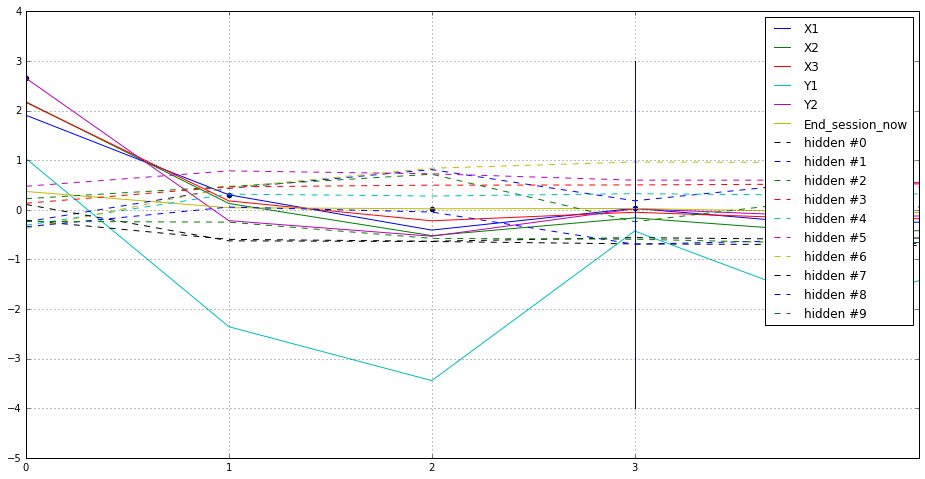

session # 2
 Y2(qv = 2.65323257446) -> 3.0(ref = 3.28674650192) |  X1(qv = 0.301838427782) -> -1.0(ref = -1.00533521175) |  X1(qv = -0.291666269302) -> -0.5(ref = -0.533514082432) |  End_session_now(qv = -0.0352779626846) -> 0.0(ref = -0.00878850463778) |  Y2(qv = -0.0490114092827) -> 0.0(ref = 0.0) | 



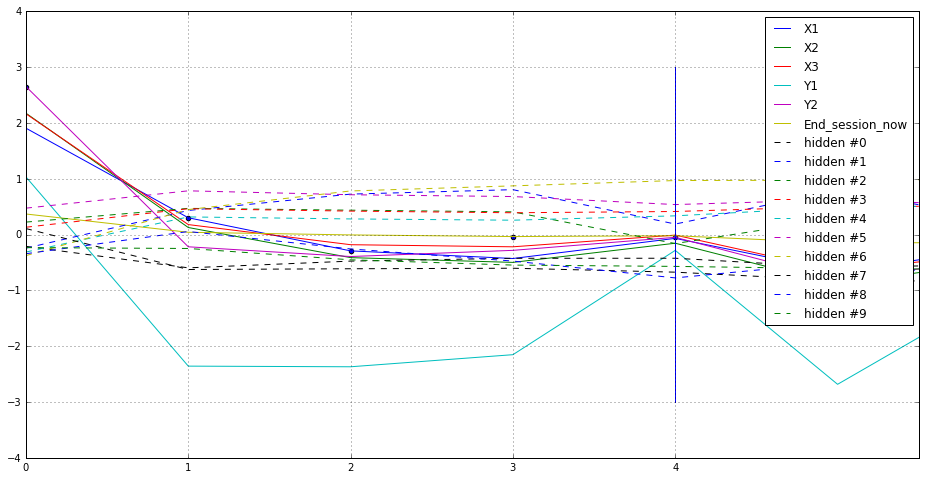

epoch 7100,loss 2.18551, epsilon 0.10550, rewards: ( e-greedy 2.38693, greedy 2.72335) 
rec 2.080 reg 0.106
epoch 7200,loss 2.35204, epsilon 0.10333, rewards: ( e-greedy 2.40991, greedy 2.72101) 
rec 2.246 reg 0.106
epoch 7300,loss 2.24827, epsilon 0.10124, rewards: ( e-greedy 2.37892, greedy 2.70224) 
rec 2.142 reg 0.106
epoch 7400,loss 2.91347, epsilon 0.09923, rewards: ( e-greedy 2.32436, greedy 2.63869) 
rec 2.807 reg 0.106
epoch 7500,loss 2.43797, epsilon 0.09730, rewards: ( e-greedy 2.35692, greedy 2.65148) 
rec 2.332 reg 0.106
epoch 7600,loss 2.12880, epsilon 0.09544, rewards: ( e-greedy 2.38290, greedy 2.66634) 
rec 2.023 reg 0.106
epoch 7700,loss 2.34364, epsilon 0.09366, rewards: ( e-greedy 2.37461, greedy 2.63970) 
rec 2.238 reg 0.106
epoch 7800,loss 2.04336, epsilon 0.09195, rewards: ( e-greedy 2.38548, greedy 2.66573) 
rec 1.938 reg 0.105
epoch 7900,loss 1.86703, epsilon 0.09030, rewards: ( e-greedy 2.42860, greedy 2.70916) 
rec 1.762 reg 0.105
epoch 8000,loss 2.19878, eps

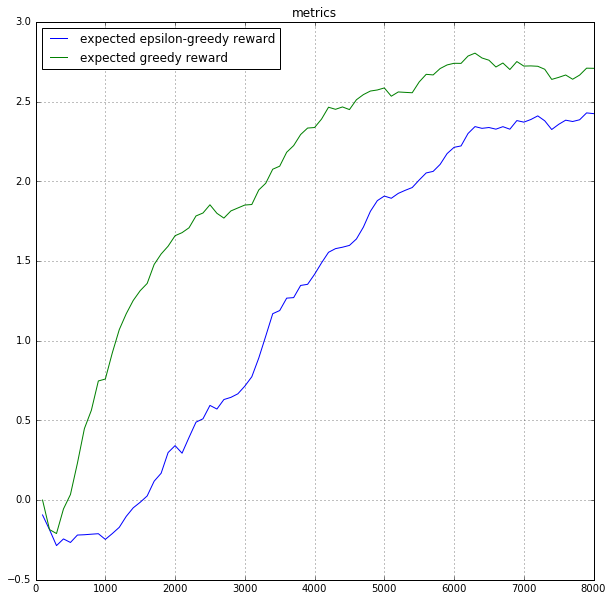

Random session examples
session # 0
 Y2(qv = 2.63566350937) -> 3.0(ref = 3.27542448044) |  X1(qv = 0.289920419455) -> 1.0(ref = 1.01117753983) |  End_session_now(qv = 0.0117658078671) -> 0.0(ref = 0.0139868101105) |  End_session_now(qv = 0.0147229582071) -> 0.0(ref = 0.0) | 



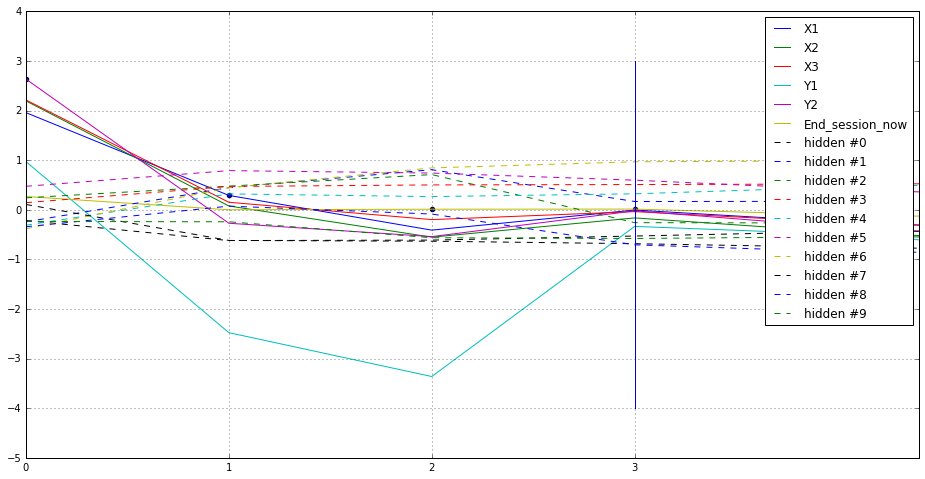

session # 1
 Y2(qv = 2.63566350937) -> 3.0(ref = 3.27542448044) |  X1(qv = 0.289920419455) -> 1.0(ref = 1.01117753983) |  End_session_now(qv = 0.0117658078671) -> 0.0(ref = 0.0139868101105) |  End_session_now(qv = 0.0147229582071) -> 0.0(ref = 0.0) | 



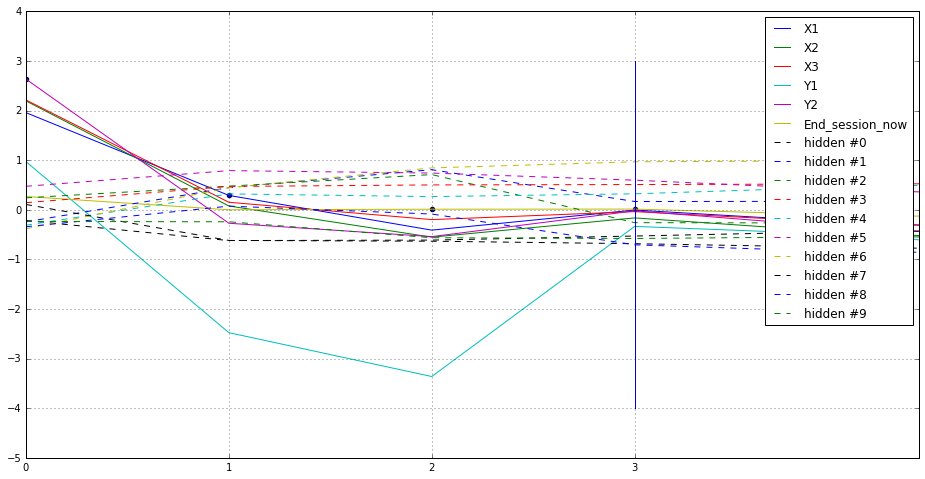

session # 2
 Y2(qv = 2.63566350937) -> 3.0(ref = 3.27542448044) |  X1(qv = 0.289920419455) -> 1.0(ref = 1.01117753983) |  End_session_now(qv = 0.0117658078671) -> 0.0(ref = 0.0139867821708) |  End_session_now(qv = 0.0147229284048) -> 0.0(ref = 0.0) | 



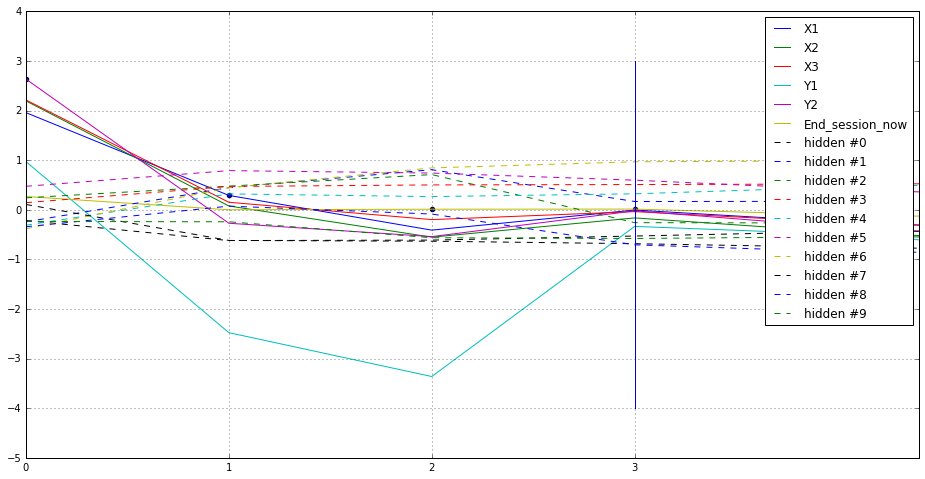

epoch 8100,loss 2.70451, epsilon 0.08721, rewards: ( e-greedy 2.37833, greedy 2.66742) 
rec 2.600 reg 0.105
epoch 8200,loss 2.17988, epsilon 0.08575, rewards: ( e-greedy 2.41050, greedy 2.67401) 
rec 2.075 reg 0.105
epoch 8300,loss 1.65150, epsilon 0.08435, rewards: ( e-greedy 2.44778, greedy 2.71661) 
rec 1.547 reg 0.104
epoch 8400,loss 1.71004, epsilon 0.08300, rewards: ( e-greedy 2.47967, greedy 2.74495) 
rec 1.606 reg 0.104
epoch 8500,loss 1.65962, epsilon 0.08170, rewards: ( e-greedy 2.48170, greedy 2.76045) 
rec 1.556 reg 0.104
epoch 8600,loss 2.47969, epsilon 0.08046, rewards: ( e-greedy 2.44020, greedy 2.73107) 
rec 2.376 reg 0.104
epoch 8700,loss 2.02364, epsilon 0.07927, rewards: ( e-greedy 2.45951, greedy 2.72463) 
rec 1.920 reg 0.104
epoch 8800,loss 2.03680, epsilon 0.07812, rewards: ( e-greedy 2.47689, greedy 2.74217) 
rec 1.934 reg 0.103
epoch 8900,loss 1.97053, epsilon 0.07702, rewards: ( e-greedy 2.49921, greedy 2.74795) 
rec 1.868 reg 0.103
epoch 9000,loss 1.98571, eps

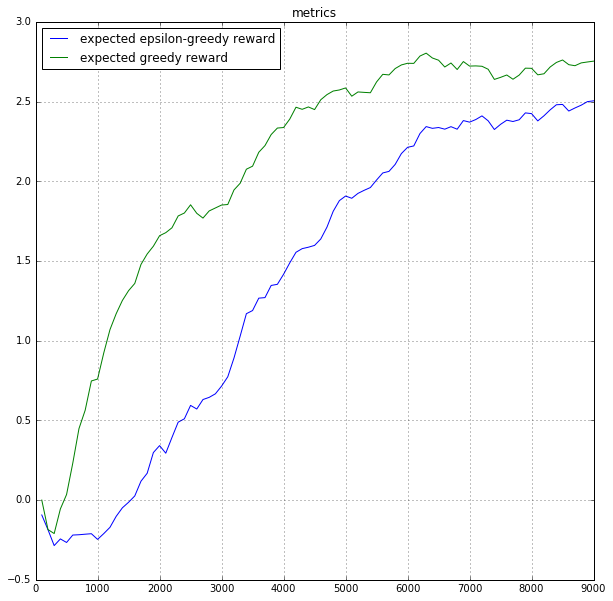

Random session examples
session # 0
 X3(qv = 2.24503755569) -> 1.0(ref = 2.76676678658) |  Y2(qv = 1.85975456238) -> 3.0(ref = 3.03560423851) |  End_session_now(qv = 0.0374781042337) -> 0.0(ref = 0.0279571134597) |  X1(qv = 0.0294285416603) -> 0.0(ref = 0.0) | 



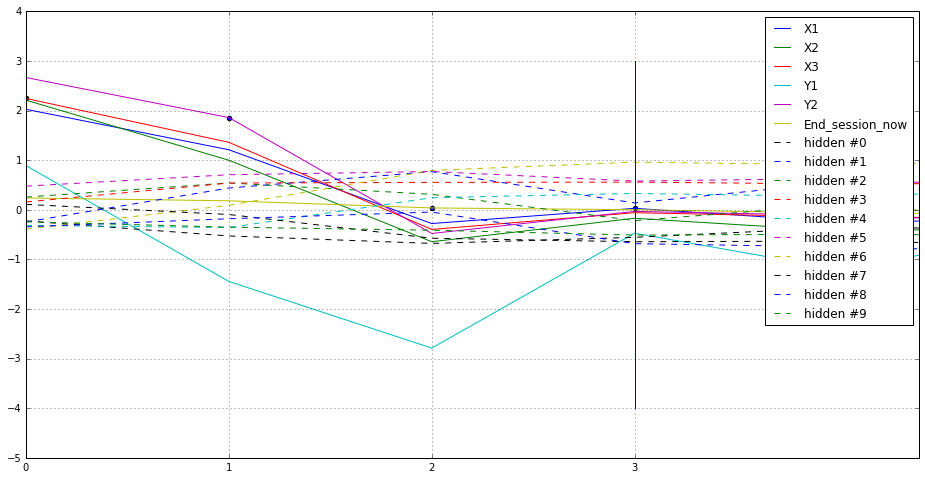

session # 1
 Y2(qv = 2.66714715958) -> 3.0(ref = 3.29878139496) |  X1(qv = 0.314506739378) -> -1.0(ref = -1.01089787483) |  End_session_now(qv = -0.0114715099335) -> 0.0(ref = -0.011288090609) |  End_session_now(qv = -0.0118822008371) -> 0.0(ref = 0.0) | 



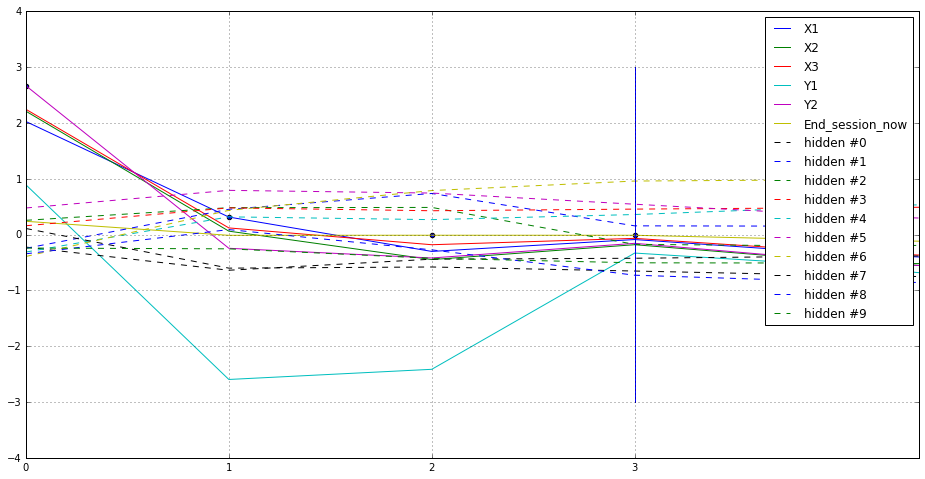

session # 2
 Y2(qv = 2.66714715958) -> -3.0(ref = 0.734842538834) |  X2(qv = 2.70272326469) -> 1.0(ref = 3.01665186882) |  Y1(qv = 2.1227915287) -> 3.0(ref = 3.04218149185) |  X2(qv = 0.0444015264511) -> -0.5(ref = -0.560059189796) |  End_session_now(qv = -0.0632201880217) -> 0.0(ref = -0.0514223128557) |  End_session_now(qv = -0.0541287511587) -> 0.0(ref = 0.0) | 



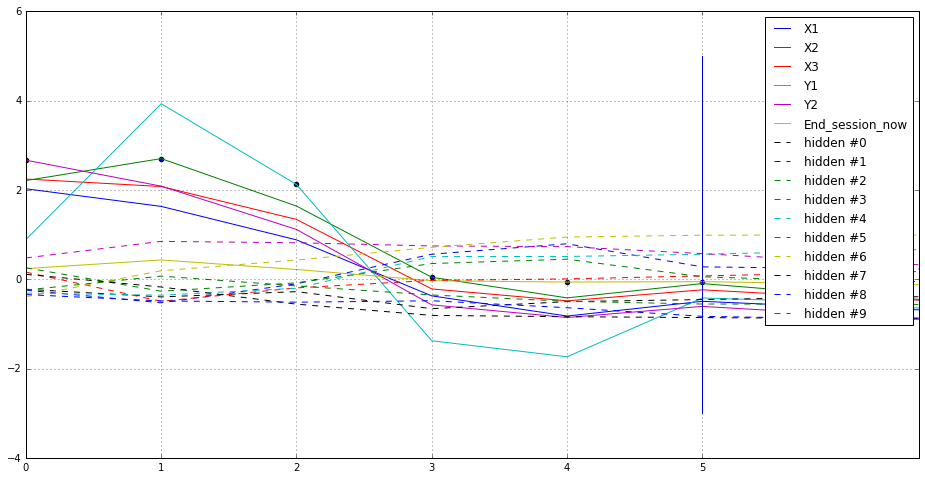

epoch 9100,loss 2.01808, epsilon 0.07494, rewards: ( e-greedy 2.49886, greedy 2.75451) 
rec 1.916 reg 0.102
epoch 9200,loss 1.94055, epsilon 0.07396, rewards: ( e-greedy 2.51397, greedy 2.76906) 
rec 1.838 reg 0.102
epoch 9300,loss 1.68760, epsilon 0.07302, rewards: ( e-greedy 2.57591, greedy 2.81549) 
rec 1.586 reg 0.102
epoch 9400,loss 1.92066, epsilon 0.07212, rewards: ( e-greedy 2.59998, greedy 2.83060) 
rec 1.819 reg 0.102
epoch 9500,loss 2.04904, epsilon 0.07125, rewards: ( e-greedy 2.61998, greedy 2.83754) 
rec 1.948 reg 0.102
epoch 9600,loss 2.00612, epsilon 0.07042, rewards: ( e-greedy 2.58299, greedy 2.81379) 
rec 1.905 reg 0.101
epoch 9700,loss 1.85040, epsilon 0.06962, rewards: ( e-greedy 2.58802, greedy 2.83574) 
rec 1.749 reg 0.101
epoch 9800,loss 1.84837, epsilon 0.06885, rewards: ( e-greedy 2.59422, greedy 2.84550) 
rec 1.748 reg 0.101
epoch 9900,loss 1.89417, epsilon 0.06811, rewards: ( e-greedy 2.59146, greedy 2.85762) 
rec 1.794 reg 0.100
epoch 10000,loss 2.44048, ep

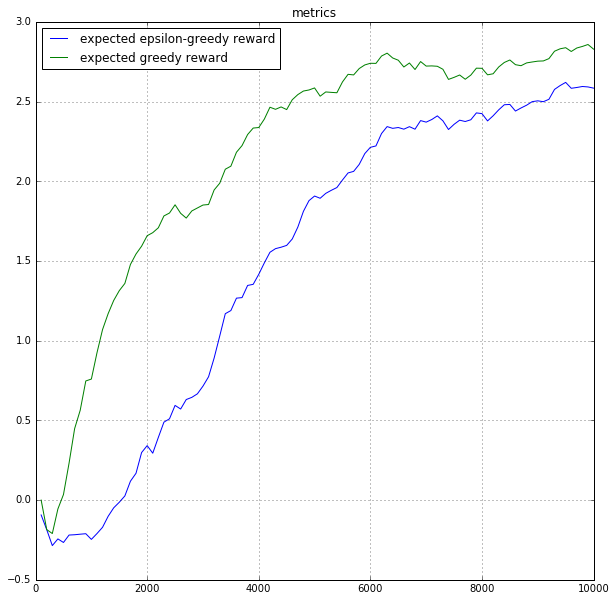

Random session examples
session # 0
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.293744057417) -> -1.0(ref = -1.00729036331) |  Y2(qv = -0.457830131054) -> -0.5(ref = -0.57840692997) |  End_session_now(qv = -0.0825336128473) -> 0.0(ref = -0.0633276253939) |  End_session_now(qv = -0.0666606575251) -> 0.0(ref = 0.0) | 



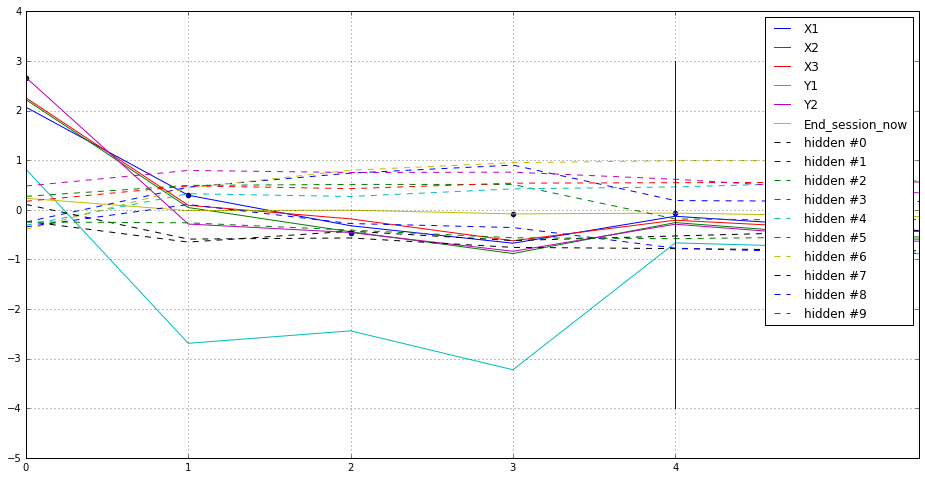

session # 1
 X1(qv = 2.06887412071) -> -1.0(ref = 1.8735408783) |  Y2(qv = 3.0247797966) -> 3.0(ref = 3.18783307076) |  X1(qv = 0.197718977928) -> -0.5(ref = -0.495892345905) |  X1(qv = -0.333994925022) -> -0.5(ref = -0.49849742651) |  End_session_now(qv = 0.0015816539526) -> 0.0(ref = 0.00849398691207) |  End_session_now(qv = 0.00894103944302) -> 0.0(ref = 0.0) | 



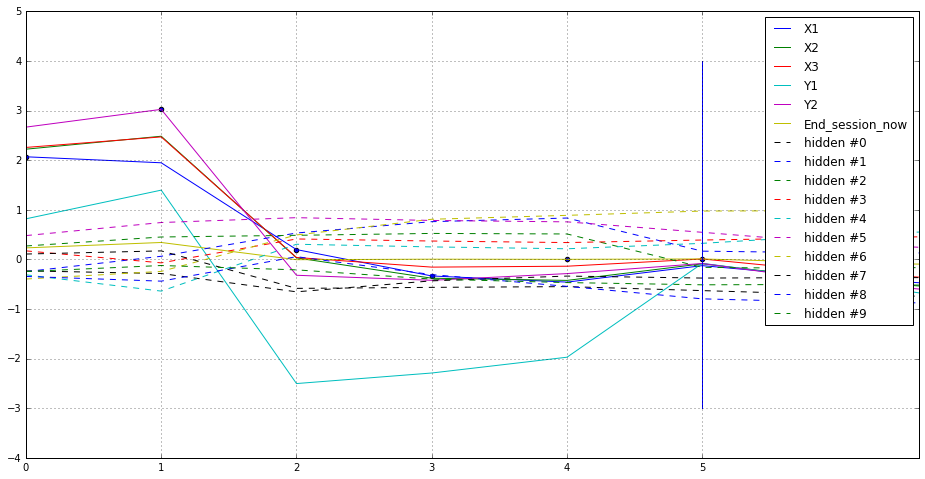

session # 2
 Y2(qv = 2.66702055931) -> -3.0(ref = 0.727306842804) |  Y1(qv = 3.92348098755) -> 3.0(ref = 3.93731999397) |  Y2(qv = 0.211735904217) -> -0.5(ref = 0.0320748090744) |  X2(qv = 0.56007874012) -> 1.0(ref = 0.998528957367) |  End_session_now(qv = -0.00154848396778) -> 0.0(ref = 0.00708988588303) |  X2(qv = 0.00746303796768) -> 0.0(ref = 0.0) | 



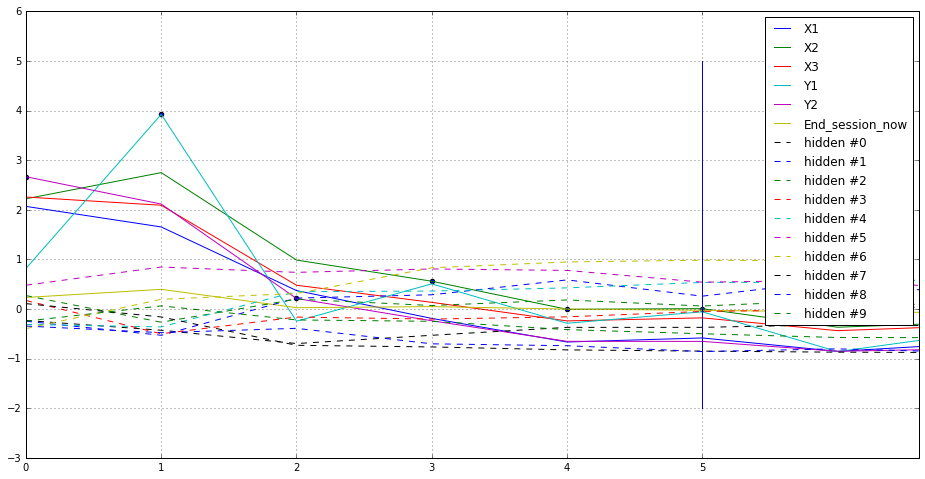

In [27]:
n_epochs = 10000
batch_size=30

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results
* in this case, a network has obvoiusly not converged, so actions ought to be suboptimal
* running network for longer may yield better results

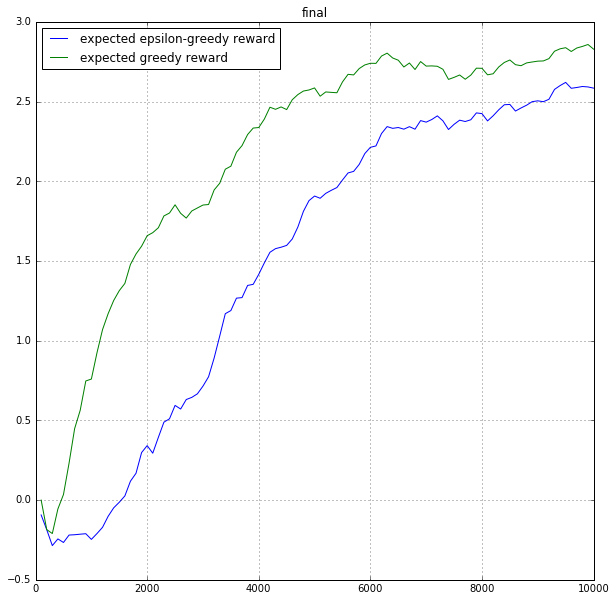

In [28]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> -1.0(ref = -1.00729036331) |  End_session_now(qv = -0.00767408311367) -> 0.0(ref = -0.00725663080812) |  End_session_now(qv = -0.00763855874538) -> 0.0(ref = 0.0) | 



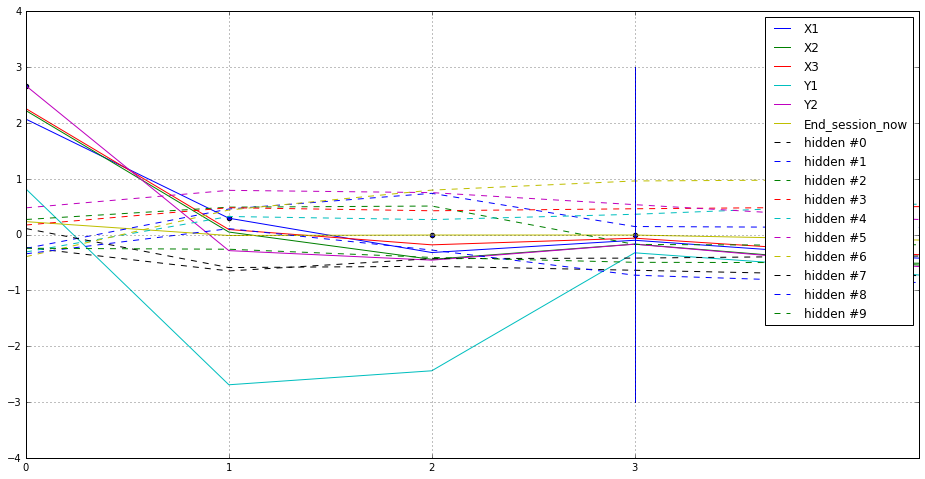

session # 1
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> 1.0(ref = 1.00872612) |  End_session_now(qv = 0.0091854184866) -> 0.0(ref = 0.00454674195498) |  End_session_now(qv = 0.00478604435921) -> 0.0(ref = 0.0) | 



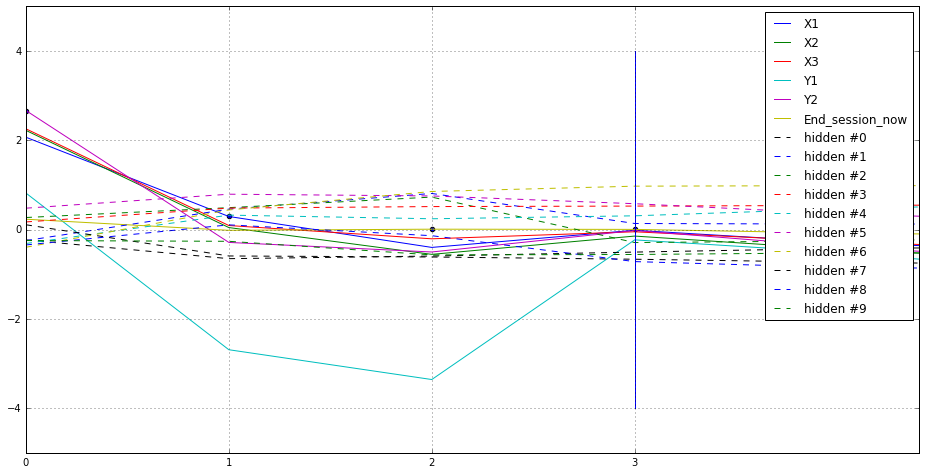

session # 2
 Y2(qv = 2.66702055931) -> -3.0(ref = 0.727306842804) |  Y1(qv = 3.92348098755) -> 3.0(ref = 3.93731999397) |  X2(qv = 0.986652612686) -> 1.0(ref = 1.01715552807) |  End_session_now(qv = 0.0180584639311) -> 0.0(ref = 0.0110508203506) |  X2(qv = 0.0116324424744) -> 0.0(ref = 0.0) | 



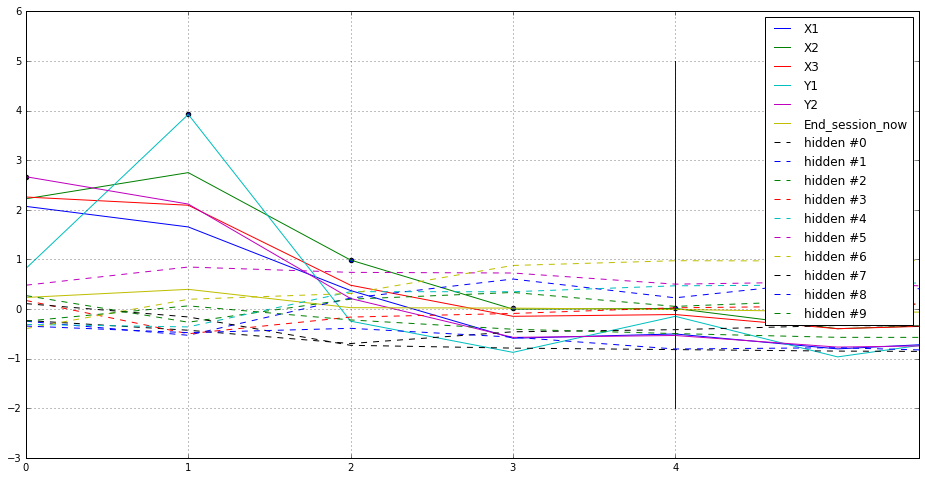

session # 3
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> 1.0(ref = 1.00872612) |  End_session_now(qv = 0.0091854184866) -> 0.0(ref = 0.00454674195498) |  End_session_now(qv = 0.00478604435921) -> 0.0(ref = 0.0) | 



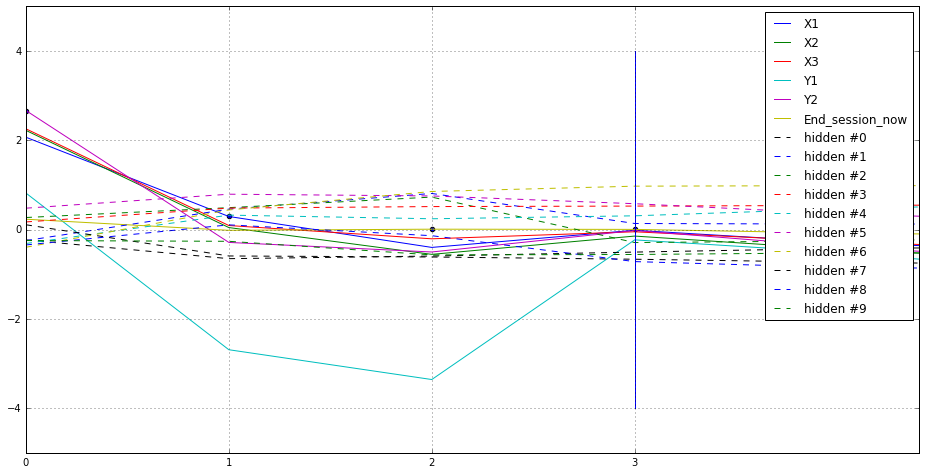

session # 4
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.293744057417) -> -1.0(ref = -1.00729036331) |  End_session_now(qv = -0.00767408311367) -> 0.0(ref = -0.00725663080812) |  End_session_now(qv = -0.00763855874538) -> 0.0(ref = 0.0) | 



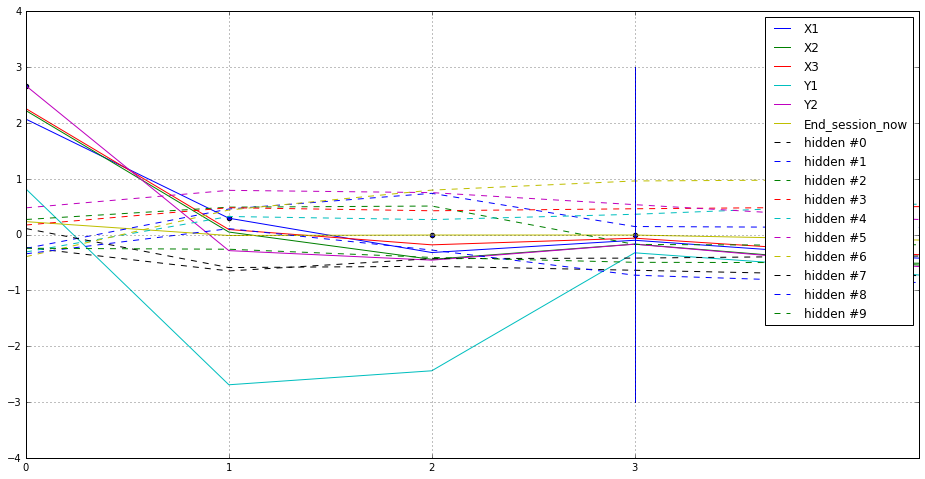

session # 5
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> 1.0(ref = 1.00872612) |  End_session_now(qv = 0.0091854184866) -> 0.0(ref = 0.00454674195498) |  End_session_now(qv = 0.00478604435921) -> 0.0(ref = 0.0) | 



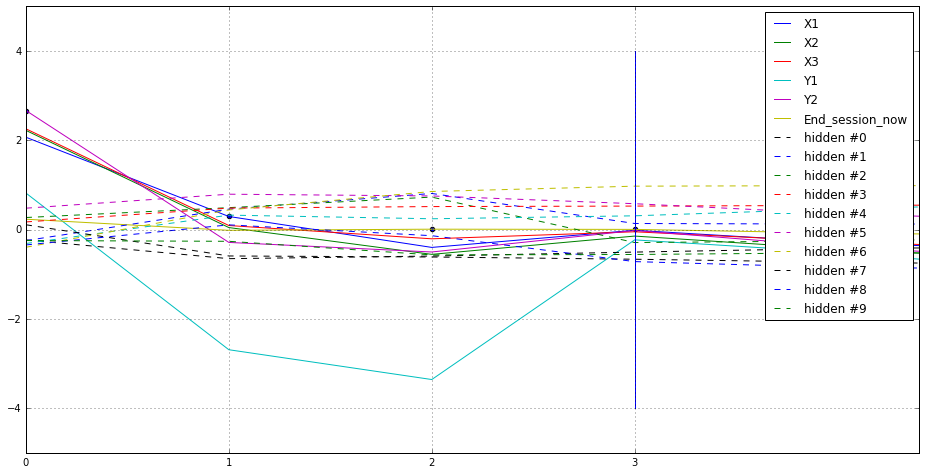

session # 6
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> 1.0(ref = 1.00872612) |  End_session_now(qv = 0.0091854184866) -> 0.0(ref = 0.00454674195498) |  End_session_now(qv = 0.00478604435921) -> 0.0(ref = 0.0) | 



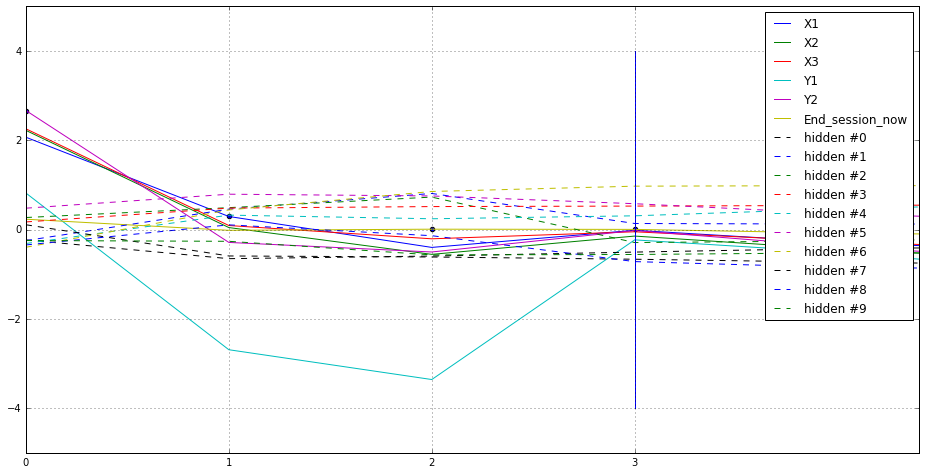

session # 7
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> -1.0(ref = -1.00729036331) |  End_session_now(qv = -0.00767408311367) -> 0.0(ref = -0.00725663080812) |  End_session_now(qv = -0.00763855874538) -> 0.0(ref = 0.0) | 



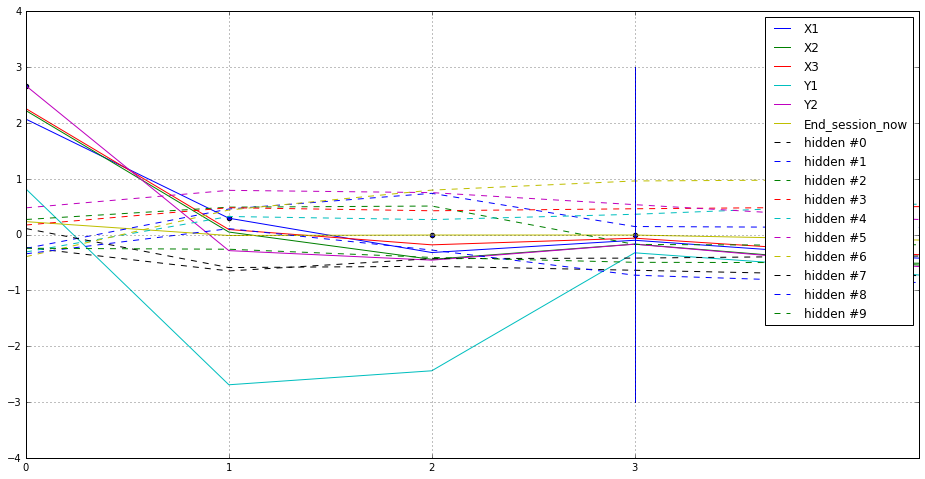

session # 8
 Y2(qv = 2.66702055931) -> 3.0(ref = 3.27905678749) |  X1(qv = 0.29374396801) -> 1.0(ref = 1.00872612) |  End_session_now(qv = 0.0091854184866) -> 0.0(ref = 0.00454674195498) |  End_session_now(qv = 0.00478604435921) -> 0.0(ref = 0.0) | 



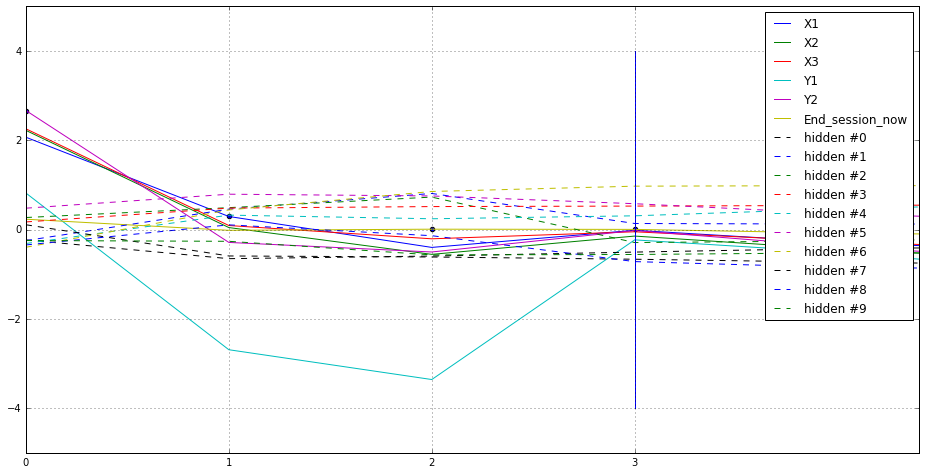

session # 9
 Y2(qv = 2.66702055931) -> -3.0(ref = 0.727306842804) |  Y1(qv = 3.92348098755) -> 3.0(ref = 3.93731999397) |  X2(qv = 0.986652553082) -> 1.0(ref = 1.01715552807) |  End_session_now(qv = 0.0180584341288) -> 0.0(ref = 0.0110508203506) |  X2(qv = 0.0116324424744) -> 0.0(ref = 0.0) | 



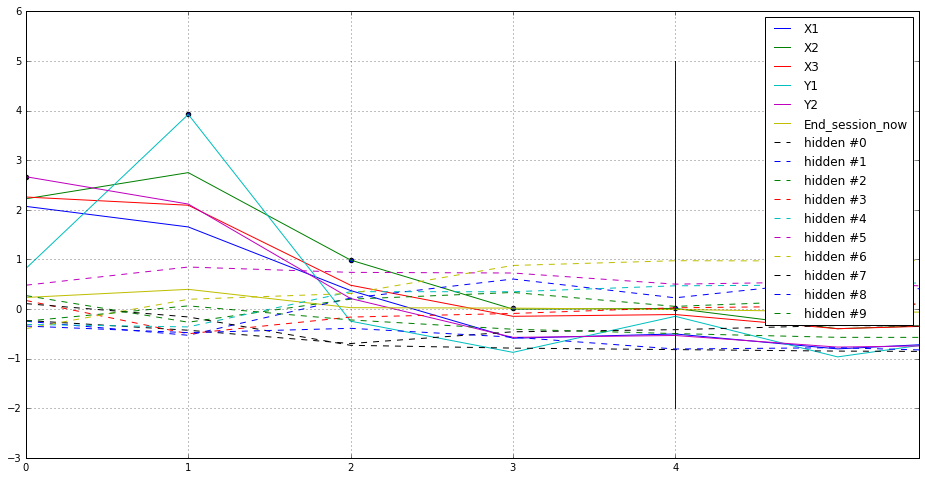

In [29]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
